I am unable to perform a deep analysis of the questions due to the time constraints. I decide to use github to share the doc and will keep on updating it if needed.

In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from urlparse import urlparse
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold

In [118]:
us_company = pd.read_csv('us_company.csv')
yahoo_fin = pd.read_csv('YahooFin.csv')

### Q1. How would you visualize the distribution of company employee count (column:EMPTOTAL)?

One of the ways to visualize the distribution is via histograms. We can start with a very basic histogram. The distribution is well bell-shaped with mean ~exp(2.5).

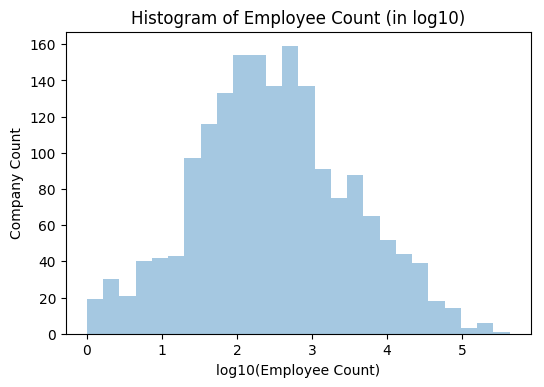

In [119]:
us_company['log_EMPTOTAL'] = us_company['EMPTOTAL'].apply(lambda x: np.log10(x))
ax = sns.distplot(us_company['log_EMPTOTAL'], norm_hist=False, kde=False)
ax.set_title('Histogram of Employee Count (in log10)')
ax.set_xlabel('log10(Employee Count)')
ax.set_ylabel('Company Count')
plt.show()

Violinplot from [seaborn](https://seaborn.pydata.org/) is a good way to visualize the distribution by groups (e.g. industry). We don't want to generate violinplot for every single industry. Instead, we label the top 7 industries and generate the violinplot respectively. The shape of the distributions are similar. The employee count for education companies are relatively small.

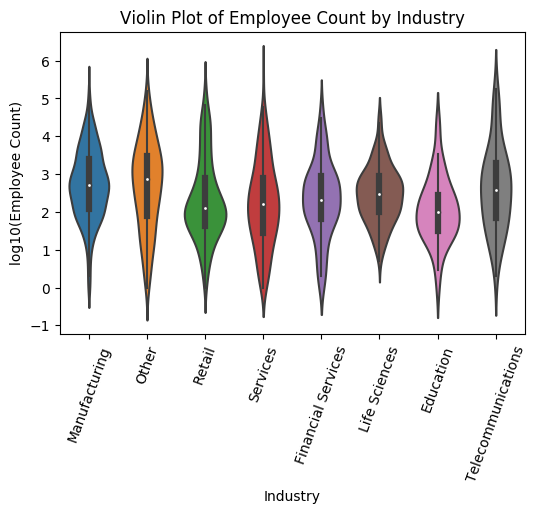

In [120]:
# Get the top 7 indistries.
top_industry = us_company.groupby('industry')['EMPTOTAL'].count().\
    reset_index().sort_values(by='EMPTOTAL', ascending=False, inplace=False).industry.tolist()[:7]
us_company['top_industry'] = us_company['industry'].apply(lambda x: x if x in top_industry else 'Other')
ax = sns.violinplot(x='top_industry', y='log_EMPTOTAL', data=us_company)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
ax.set_title('Violin Plot of Employee Count by Industry')
ax.set_xlabel('Industry')
ax.set_ylabel('log10(Employee Count)')
plt.show()

### Q2. Is Company data accurate in terms of employee count? If not, could you output the top 10 high accurate companies and the bottom 10 low accurate ones?

We can fit an ML model to predict the employee count for each company and compare against the actual employee count. However, we should keep in mind that the deviance could be due to one of the two errors:
1. The actual employee count is not accurate.
2. The model fitting result is not good.

Before we can fit the ML model, we need to make a few assumptions:
1. The columns LOCALSALES and USSALES are accurate.

Let's start with a very simple RF model.

In [121]:
# For column industry, vertical and, category, we only keep the top X catetories.
rf_industry = us_company.groupby('industry')['EMPTOTAL'].count().\
    reset_index().sort_values(by='EMPTOTAL', ascending=False, inplace=False).iloc[:10]['industry'].tolist()
rf_vertical = us_company.groupby('vertical')['EMPTOTAL'].count().\
    reset_index().sort_values(by='EMPTOTAL', ascending=False, inplace=False).iloc[:20]['vertical'].tolist()
rf_category = us_company.groupby('category')['EMPTOTAL'].count().\
    reset_index().sort_values(by='EMPTOTAL', ascending=False, inplace=False).iloc[:20]['category'].tolist()

def filter_top_list(x, top_list):
    if pd.isnull(x) or x not in top_list:
        return 'Other'
    else:
        return x
    
us_company['rf_industry'] = us_company['industry'].apply(lambda x: filter_top_list(x, top_list=rf_industry))
us_company['rf_vertical'] = us_company['vertical'].apply(lambda x: filter_top_list(x, top_list=rf_vertical))
us_company['rf_category'] = us_company['category'].apply(lambda x: filter_top_list(x, top_list=rf_category))
us_company['log_lcoalsales'] = us_company['LOCALSALES'].apply(lambda x: np.log(x + 0.0001))
us_company['log_ussales'] = us_company['USSALES'].apply(lambda x: np.log(x + 0.0001))

# We perform log transformation of LOCALSALES, USSALES, and EMPTOTAL.
feature_list =[us_company[['log_lcoalsales', 'log_ussales']]]
for cal_col in ['rf_industry', 'rf_vertical', 'rf_category']:
    feature_list.append(pd.get_dummies(us_company[cal_col], prefix=cal_col))
feature = pd.concat(feature_list, axis=1)
Y = np.log(us_company['EMPTOTAL'])

We use 10 folder CVs to estimate the model out of same performance. The model performance is shown below. The CV can also be used for tuning hyper-parameters including:
1. top X industries, verticals, categories that we should be used for the RF model.
2. Other parameters that config the RF model.

In [122]:
RF_model = RandomForestRegressor(n_estimators=800)
kf = KFold(n_splits=10, shuffle=True)
result = []
for train_index, test_index in kf.split(feature):
    X_train, X_test = feature.iloc[train_index], feature.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    RF_model.fit(X_train, y_train)
    y_pred = RF_model.predict(X_test)
    result.append({
        'train_index': train_index,
        'test_index': test_index,
        'y_train': y_train,
        'y_pred': y_pred,
        'MAE_log': np.mean(abs(y_test - y_pred)),
        'MAE': np.mean(abs(np.exp(y_test) - np.exp(y_pred))),
        'RMSE_log': np.sqrt(np.mean((y_test - y_pred) ** 2)),
        'RMSE': np.sqrt(np.mean((np.exp(y_test) - np.exp(y_pred)) ** 2)),
        'feature_importances': RF_model.feature_importances_
    })
print 'Model performance:'
{
    'MAE_log': round(np.mean([x['MAE_log'] for x in result]), 2), 
    'MAE': round(np.mean([x['MAE'] for x in result]), 2),
    'RMSE_log': round(np.mean([x['RMSE_log'] for x in result]), 2),
    'RMSE': round(np.mean([x['RMSE'] for x in result]), 2)
}

Model performance:


{'MAE': 2628.11, 'MAE_log': 0.95, 'RMSE': 12468.62, 'RMSE_log': 1.36}

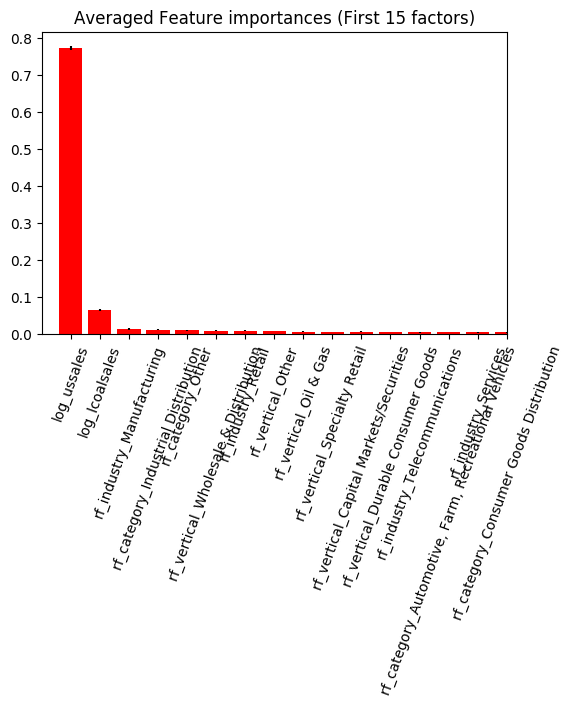

In [123]:
importances_pd = pd.DataFrame([x['feature_importances'] for x in result])
importances = importances_pd.mean()
std = importances_pd.std(axis=0)
data_col = feature.columns
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Averaged Feature importances (First 15 factors)")
plt.bar(range(feature.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(feature.shape[1]), [data_col[i] for i in indices], rotation=70)
plt.xlim([-1, 15])
plt.show()

Ideally, we should use leave-one-out method to estimate the employee count for each company: for each company, we use all the records but the employee count from that company for model fitting. Then we make predict over the company we left out. However, due to the computational constrain, we will skip that part and use all the data for the model training.

In [124]:
RF_model.fit(feature, Y)
pred = np.round(np.exp(RF_model.predict(feature)))
company_pred = pd.concat(
    [us_company[['COMPANY-NAME', 'EMPTOTAL']], pd.Series(pred, name='pred')], axis=1)
company_pred['abs_diff'] = np.abs(company_pred.EMPTOTAL - company_pred.pred)
company_pred.sort_values(by='abs_diff', inplace=True)

Top 10 high accurate companies:

In [125]:
company_pred.head(10)

,COMPANY-NAME,EMPTOTAL,pred,abs_diff
1094,Conocophillips International Inc.,20,20.0,0.0
776,"Appfolio, Inc.",8,8.0,0.0
1209,EBAY SINGAPORE SERVICES PRIVATE LIMITED,20,20.0,0.0
1045,EBAY SINGAPORE SERVICES PRIVATE LIMITED,20,20.0,0.0
1552,"Calvary Bible Church, Inc",15,15.0,0.0
241,Nuance Communications Healthcare Germany GmbH,15,15.0,0.0
821,Melrose Cooperative Bank,20,20.0,0.0
576,Genesee & Wyoming Canada Inc,230,230.0,0.0
1170,John Ryan Enterprises Inc,18,18.0,0.0
66,Cree Canada Corp,9,9.0,0.0


Bottom 10 low accurate companies:

In [126]:
company_pred.tail(10).iloc[::-1]

,COMPANY-NAME,EMPTOTAL,pred,abs_diff
1427,International Business Machines Corporation,431212,241955.0,189257.0
509,Verizon Communications Inc.,183400,23246.0,160154.0
322,CVS Caremark Corporation,208000,104943.0,103057.0
1421,United Technologies Corporation,212000,121305.0,90695.0
1232,Fedex Corporation,160700,73298.0,87402.0
411,"Best Buy Co., Inc.",165000,80709.0,84291.0
793,Starbucks Corporation,182000,112711.0,69289.0
1550,Caesars Entertainment Corporation,68000,4961.0,63039.0
22,Lear Corporation,122300,64374.0,57926.0
688,Intel Corporation,107600,61379.0,46221.0


### Q3. Come up with any interesting analysis/visualization of this data?

1. Estimate the company market cap given categorical variable, employee count, local sales, and US sales.

2. Inspired by Rosling's video [here](https://www.youtube.com/watch?v=jbkSRLYSojo), if we can leverage fn [gvisMotionChart](https://www.rdocumentation.org/packages/googleVis/versions/0.6.0/topics/gvisMotionChart) from R package [googleVis](https://cran.r-project.org/web/packages/googleVis/index.html). We can plot with the following configs:
    * Y axis: localsales or ussales
    * X axis: employee count
    * Marker size: market cap.
    * Color: Industry